Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


You won't be able to just copy from the lesson notebook to this assignment.

- Because the lesson was ***regression***, but the assignment is ***classification.***
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
# Filenames of submissions to ensemble
files = [      
         '/content/waterpump-submission-05.csv', '/content/waterpump-submission-06.csv',
         '/content/waterpump-submission-15.csv', '/content/waterpump-submission-16.csv',
         '/content/waterpump-submission-18 (3).csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submissionB.csv', index=False)


In [0]:
submission_best = pd.read_csv('/content/my-ultimate-ensemble-submission.csv')
submission_best.shape

(14358, 2)

In [0]:
submission_best

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,functional
14356,33492,functional


In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# all imports needed for this sheet

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [0]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
# convert strings in target column to integers for use in future functions

train['status_group'] = train['status_group'].replace('functional', 1)
train['status_group'] = train['status_group'].replace('non functional', 2)
train['status_group'] = train['status_group'].replace('functional needs repair', 3)



In [0]:
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

In [0]:
# create funtion to wrangle each set in same way

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    # after evaluation, decided to remove whether column is missing
    # as cross validation showed it was not important
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies)
    unusable_variance = ['recorded_by']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()

    # Engineer feature: height of well is 1500 or lower
    X['lower_height'] = X['gps_height'] <= 1500

    # Engineer feature: year recorded 2012 or later
    X['post_2012_rec'] = X['year_recorded'] >= 2012

    # Engineer feature: constructed 2008 or later
    X['not_old'] = X['construction_year'] >= 2008

    # Engineer feature: funder is in top 1 funders
    top1 = train['installer'].value_counts()[:1].index
    X['top_1_installer'] = X['installer'].isin(top1)
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [82]:
%%time

# Arrange data to include all categorical features
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# pipeline, with ordinal encoder
pipeline = make_pipeline(
    #ce.OneHotEncoder(use_cat_names=True, cols=['lower_height']), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(n_estimators=210, max_depth=40, max_features="auto", 
                           random_state=42, n_jobs=-1, warm_start=False, 
                           )
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8141414141414142
CPU times: user 44.3 s, sys: 169 ms, total: 44.5 s
Wall time: 23.9 s


In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
#le.fit([1, 2, 2, 6])

In [93]:
param_dist = {'objective':'binary:logistic', 'n_estimators':2}

clf = xgb.XGBModel(**param_dist)
#le.fit(X_train)
le.fit(y_train)
clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric='logloss',
        verbose=False)

evals_result = clf.evals_result()

ValueError: ignored

In [0]:

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [0]:
# convert integers in target column to strings for use in kaggle submission

train['status_group'] = train['status_group'].replace('functional', 1)
train['status_group'] = train['status_group'].replace('non functional', 2)
train['status_group'] = train['status_group'].replace('functional needs repair', 3)



In [0]:
a = y_pred
b = ['functional' if i == 1 else 'non functional' if i == 2 else 'functional' for i in a]

In [0]:
y_pred = b
y_pred

In [18]:
y_pred = pipeline.predict(X_test) 
# make submission

submission = test[['id']].copy()
submission['status_group'] = y_pred
# submission['status_group']
submission.to_csv('waterpump-submission-19.csv', index=False)

sub_df = pd.read_csv('/content/waterpump-submission-19.csv')

sub_df.shape

(14358, 2)

In [0]:
y_pred

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

Best hyperparameters {
  'randomforestclassifier__max_depth': 40,
  'randomforestclassifier__max_features': 0.08642105949487566,
  'randomforestclassifier__n_estimators': 250, 
  'simpleimputer__strategy': 'most_frequent',
  'targetencoder__min_samples_leaf': 285, 
  'targetencoder__smoothing': 310.8115391005846
  }
Cross-validation MAE -0.7939604377104377

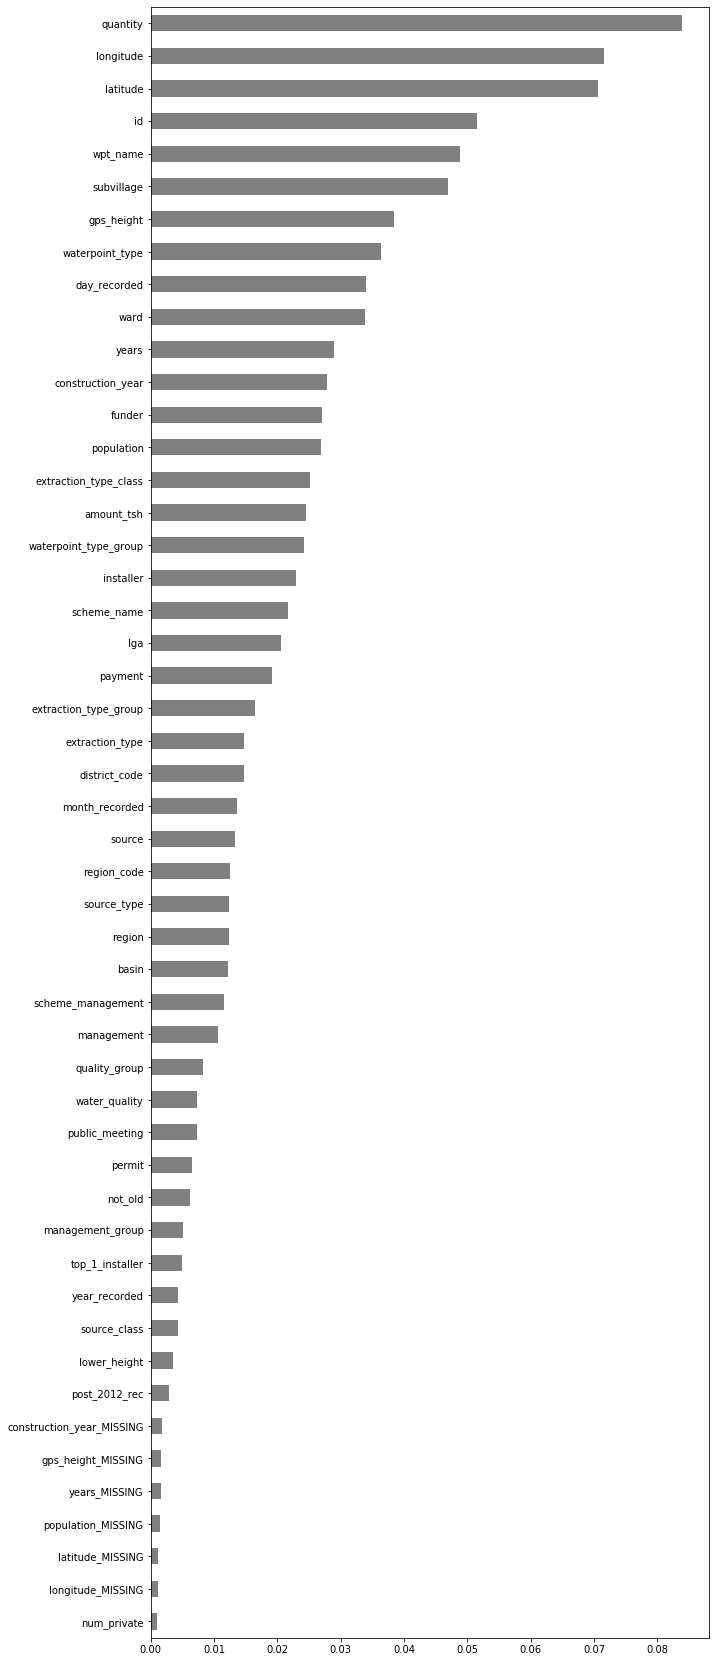

In [17]:
# Linear models have coefficients whereas decision trees have "Feature Importances"
import matplotlib.pyplot as plt

model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey')

In [0]:
k = 5
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'MAE for {k} folds:', -scores)

MAE for 5 folds: [-0.80936349 -0.80904787 -0.8052399  -0.80534512 -0.80256788]


In [0]:
scores.mean()

0.8063128519444117

In [29]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestclassifier'])

Model Hyperparameters:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=210,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


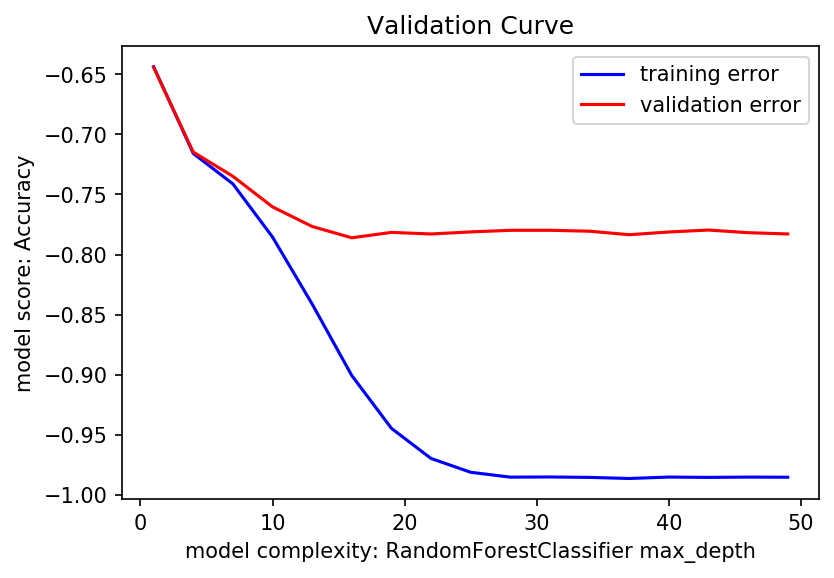

In [0]:
%matplotlib inline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier()
)

depth = range(1, 50, 3)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='randomforestclassifier__max_depth', 
    param_range=depth, scoring='accuracy', 
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve')
plt.xlabel('model complexity: RandomForestClassifier max_depth')
plt.ylabel('model score: Accuracy')
plt.legend();

In [0]:
y_pred = pipeline.predict(X_test) 

In [0]:
# make submission

submission = test[['id']].copy()
submission['status_group'] = y_pred
# submission['status_group']
submission.to_csv('waterpump-submission-17.csv', index=False)

In [0]:
sub_df = pd.read_csv('/content/waterpump-submission-17.csv')

In [0]:
sub_df.shape

(14358, 2)

In [0]:
from scipy.stats import randint, uniform

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000), 
    'targetencoder__smoothing': uniform(1, 1000), 
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'], 
    'randomforestclassifier__n_estimators': range(50, 301, 50), 
    'randomforestclassifier__max_depth': [20, 30, 40, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] randomforestclassifier__max_depth=30, randomforestclassifier__max_features=0.2861825260674927, randomforestclassifier__n_estimators=200, simpleimputer__strategy=mean, targetencoder__min_samples_leaf=183, targetencoder__smoothing=399.39180477915403 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__max_depth=30, randomforestclassifier__max_features=0.2861825260674927, randomforestclassifier__n_estimators=200, simpleimputer__strategy=mean, targetencoder__min_samples_leaf=183, targetencoder__smoothing=399.39180477915403, score=(train=0.999, test=0.772), total=  30.2s
[CV] randomforestclassifier__max_depth=30, randomforestclassifier__max_features=0.2861825260674927, randomforestclassifier__n_estimators=200, simpleimputer__strategy=mean, targetencoder__min_samples_leaf=183, targetencoder__smoothing=399.39180477915403 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.5s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=30, randomforestclassifier__max_features=0.2861825260674927, randomforestclassifier__n_estimators=200, simpleimputer__strategy=mean, targetencoder__min_samples_leaf=183, targetencoder__smoothing=399.39180477915403, score=(train=1.000, test=0.776), total=  29.6s
[CV] randomforestclassifier__max_depth=30, randomforestclassifier__max_features=0.2861825260674927, randomforestclassifier__n_estimators=200, simpleimputer__strategy=mean, targetencoder__min_samples_leaf=183, targetencoder__smoothing=399.39180477915403 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=30, randomforestclassifier__max_features=0.2861825260674927, randomforestclassifier__n_estimators=200, simpleimputer__strategy=mean, targetencoder__min_samples_leaf=183, targetencoder__smoothing=399.39180477915403, score=(train=0.999, test=0.776), total=  30.2s
[CV] randomforestclassifier__max_depth=40, randomforestclassifier__max_features=0.6685045252187286, randomforestclassifier__n_estimators=300, simpleimputer__strategy=median, targetencoder__min_samples_leaf=859, targetencoder__smoothing=368.28684116593615 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=40, randomforestclassifier__max_features=0.6685045252187286, randomforestclassifier__n_estimators=300, simpleimputer__strategy=median, targetencoder__min_samples_leaf=859, targetencoder__smoothing=368.28684116593615, score=(train=1.000, test=0.768), total= 1.6min
[CV] randomforestclassifier__max_depth=40, randomforestclassifier__max_features=0.6685045252187286, randomforestclassifier__n_estimators=300, simpleimputer__strategy=median, targetencoder__min_samples_leaf=859, targetencoder__smoothing=368.28684116593615 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.3min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=40, randomforestclassifier__max_features=0.6685045252187286, randomforestclassifier__n_estimators=300, simpleimputer__strategy=median, targetencoder__min_samples_leaf=859, targetencoder__smoothing=368.28684116593615, score=(train=1.000, test=0.772), total= 1.6min
[CV] randomforestclassifier__max_depth=40, randomforestclassifier__max_features=0.6685045252187286, randomforestclassifier__n_estimators=300, simpleimputer__strategy=median, targetencoder__min_samples_leaf=859, targetencoder__smoothing=368.28684116593615 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=40, randomforestclassifier__max_features=0.6685045252187286, randomforestclassifier__n_estimators=300, simpleimputer__strategy=median, targetencoder__min_samples_leaf=859, targetencoder__smoothing=368.28684116593615, score=(train=1.000, test=0.771), total= 1.6min
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.29741333090385347, randomforestclassifier__n_estimators=250, simpleimputer__strategy=mean, targetencoder__min_samples_leaf=858, targetencoder__smoothing=920.3785468685412 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.5min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.29741333090385347, randomforestclassifier__n_estimators=250, simpleimputer__strategy=mean, targetencoder__min_samples_leaf=858, targetencoder__smoothing=920.3785468685412, score=(train=1.000, test=0.772), total=  39.0s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.29741333090385347, randomforestclassifier__n_estimators=250, simpleimputer__strategy=mean, targetencoder__min_samples_leaf=858, targetencoder__smoothing=920.3785468685412 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  7.2min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.29741333090385347, randomforestclassifier__n_estimators=250, simpleimputer__strategy=mean, targetencoder__min_samples_leaf=858, targetencoder__smoothing=920.3785468685412, score=(train=1.000, test=0.777), total=  39.1s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.29741333090385347, randomforestclassifier__n_estimators=250, simpleimputer__strategy=mean, targetencoder__min_samples_leaf=858, targetencoder__smoothing=920.3785468685412 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  7.9min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.29741333090385347, randomforestclassifier__n_estimators=250, simpleimputer__strategy=mean, targetencoder__min_samples_leaf=858, targetencoder__smoothing=920.3785468685412, score=(train=1.000, test=0.776), total=  39.9s
[CV] randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.6106816314094852, randomforestclassifier__n_estimators=250, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=11, targetencoder__smoothing=630.0490731967576 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.7min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.6106816314094852, randomforestclassifier__n_estimators=250, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=11, targetencoder__smoothing=630.0490731967576, score=(train=0.955, test=0.764), total= 1.1min
[CV] randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.6106816314094852, randomforestclassifier__n_estimators=250, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=11, targetencoder__smoothing=630.0490731967576 
[CV]  randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.6106816314094852, randomforestclassifier__n_estimators=250, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=11, targetencoder__smoothing=630.0490731967576, score=(train=0.952, test=0.770), total= 1.1min
[CV] randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.6106816314094852, randomforestclassifie

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 33.2min finished


In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy score', -search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 40, 'randomforestclassifier__max_features': 0.08642105949487566, 'randomforestclassifier__n_estimators': 250, 'simpleimputer__strategy': 'most_frequent', 'targetencoder__min_samples_leaf': 285, 'targetencoder__smoothing': 310.8115391005846}
Cross-validation accuracy score -0.7939604377104377
